# House Price Prediction — Full ML Project


In [1]:
# Upload 'housing.csv'.
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('Uploaded file:', fn)

DATA_PATH = list(uploaded.keys())[0] if uploaded else '/content/housing.csv'
print('DATA_PATH =', DATA_PATH)

Saving housing.csv to housing.csv
Uploaded file: housing.csv
DATA_PATH = housing.csv


In [3]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

print('Libraries imported.')


Libraries imported.


In [4]:
# Load dataset
DATA_PATH = 'housing.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Please upload the file or change DATA_PATH.")
df = pd.read_csv(DATA_PATH)
print('Data loaded. Shape:', df.shape)
df.head()

Data loaded. Shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Columns (10): ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

Data types:
 longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Missing values per column:
 total_bedrooms        207
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
longitude,20640.0,NaN,NaN,NaN,-119.569704,2.003532,-124.35,-121.8,-118.49,-118.01,-114.31
latitude,20640.0,NaN,NaN,NaN,35.631861,2.135952,32.54,33.93,34.26,37.71,41.95
housing_median_age,20640.0,NaN,NaN,NaN,28.639486,12.585558,1.0,18.0,29.0,37.0,52.0
total_rooms,20640.0,NaN,NaN,NaN,2635.763081,2181.615252,2.0,1447.75,2127.0,3148.0,39320.0
total_bedrooms,20433.0,NaN,NaN,NaN,537.870553,421.38507,1.0,296.0,435.0,647.0,6445.0
population,20640.0,NaN,NaN,NaN,1425.476744,1132.462122,3.0,787.0,1166.0,1725.0,35682.0
households,20640.0,NaN,NaN,NaN,499.53968,382.329753,1.0,280.0,409.0,605.0,6082.0
median_income,20640.0,NaN,NaN,NaN,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,NaN,NaN,NaN,206855.816909,115395.615874,14999.0,119600.0,179700.0,264725.0,500001.0
ocean_proximity,20640,5,<1H OCEAN,9136,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Assumed target column: median_house_value


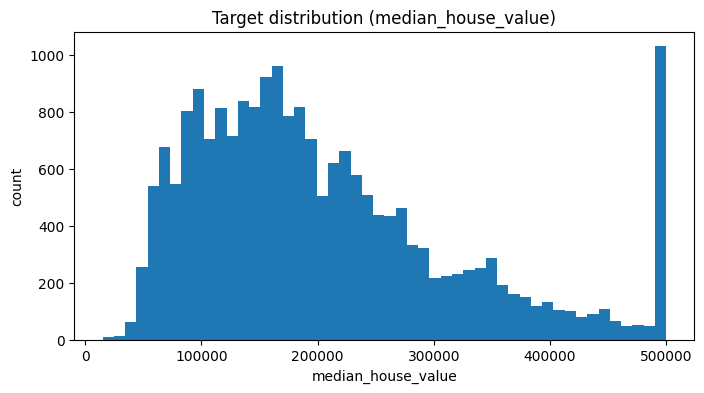

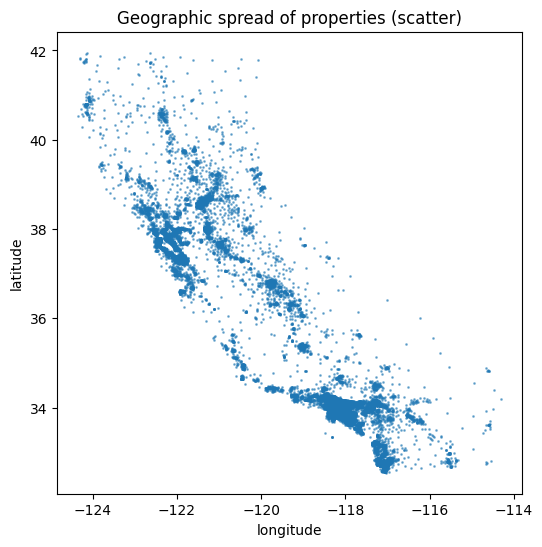


Top correlations with target:
 median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


In [5]:
# --- Exploratory Data Analysis (EDA) ---
print('Columns ({}):'.format(len(df.columns)), list(df.columns))
print('\nData types:\n', df.dtypes)
print('\nMissing values per column:\n', df.isna().sum().sort_values(ascending=False).head(20))

# Quick descriptive statistics
display(df.describe(include='all').T)

# Visualize target distribution
target_col = 'median_house_value' if 'median_house_value' in df.columns else df.columns[-1]
print('Assumed target column:', target_col)
plt.figure(figsize=(8,4))
plt.hist(df[target_col].dropna(), bins=50)
plt.title('Target distribution (' + target_col + ')')
plt.xlabel(target_col); plt.ylabel('count')
plt.show()

# Scatter plot simple (if coordinates exist)
if set(['longitude','latitude']).issubset(df.columns):
    plt.figure(figsize=(6,6))
    plt.scatter(df['longitude'], df['latitude'], s=1, alpha=0.5)
    plt.title('Geographic spread of properties (scatter)')
    plt.xlabel('longitude'); plt.ylabel('latitude')
    plt.show()

# Correlation with target (numeric only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    corr = df[num_cols].corr()[target_col].sort_values(ascending=False)
    print('\nTop correlations with target:\n', corr.head(15))
else:
    print('Target not numeric or not found for correlation.')

In [8]:
# --- Preprocessing & Feature Engineering ---

# 1) Identify column types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target from numeric features
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Numeric cols:', numeric_cols[:10], '... (total {})'.format(len(numeric_cols)))
print('Categorical cols:', cat_cols)

# 2) Example feature engineering: add rooms_per_household, bedrooms_per_room, population_per_household
def add_engineered_features(X):
    X = X.copy()
    # safe guards for missing columns
    if 'total_rooms' in X.columns and 'households' in X.columns:
        X['rooms_per_household'] = X['total_rooms'] / X['households']
    if 'total_bedrooms' in X.columns and 'total_rooms' in X.columns:
        X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
    if 'population' in X.columns and 'households' in X.columns:
        X['population_per_household'] = X['population'] / X['households']
    return X

# Wrap as FunctionTransformer for pipeline compatibility
feature_creator = FunctionTransformer(add_engineered_features)

# Update numeric list with engineered features (we can't list them until after transformer runs at fit time).
engineered_features = ['rooms_per_household','bedrooms_per_room','population_per_household']

# 3) Numeric pipeline: impute -> scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 4) Categorical pipeline: impute -> one-hot (use handle_unknown='ignore')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # default outputs sparse matrix
])


# 5) ColumnTransformer. Note: engineered features will be added by an upstream transformer in the main pipeline.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')  # drop any other columns by default

print('Preprocessing pipeline prepared.')

Numeric cols: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'] ... (total 8)
Categorical cols: ['ocean_proximity']
Preprocessing pipeline prepared.


In [11]:
# --- Train-test split and complete pipelines for models ---
X = df.drop(columns=[target_col])
y = df[target_col].copy()

# Quick train-test split (stratify if you have a categorical like ocean_proximity with many values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build full pipeline: feature creation -> preprocessing -> model
def make_pipeline(model):
    return Pipeline(steps=[
        ('feat_eng', feature_creator),
        ('preproc', preprocessor),
        ('model', model)
    ])

# Instantiate baseline models
lr_pipeline = make_pipeline(LinearRegression())
rf_pipeline = make_pipeline(RandomForestRegressor(random_state=42, n_jobs=-1))

print('Pipelines ready. Training baseline models...')

# Train baseline Linear Regression
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print('\nLinear Regression baseline results:')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print('MAE:', mean_absolute_error(y_test, y_pred_lr))
print('R2:', r2_score(y_test, y_pred_lr))

# Train baseline Random Forest (with default params; can be slow depending on data size)
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print('\nRandom Forest baseline results:')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print('MAE:', mean_absolute_error(y_test, y_pred_rf))
print('R2:', r2_score(y_test, y_pred_rf))

Pipelines ready. Training baseline models...

Linear Regression baseline results:
RMSE: 70059.19333925014
MAE: 50670.48923565361
R2: 0.6254382675296266

Random Forest baseline results:
RMSE: 48941.70034309343
MAE: 31628.40731104651
R2: 0.8172104989933294


In [13]:
# --- Hyperparameter tuning for Random Forest using RandomizedSearchCV ---
param_dist = {
    'model__n_estimators': [50, 100, 200, 400],
    'model__max_depth': [None, 10, 20, 30, 50],
    'model__max_features': ['sqrt','log2', 0.2, 0.5],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rs = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist, n_iter=25,
                        cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
rs.fit(X_train, y_train)
print('Best params (RandomizedSearchCV):', rs.best_params_)
best_rf = rs.best_estimator_

# Evaluate best estimator on test set
y_pred_best_rf = best_rf.predict(X_test)
print('\nTuned Random Forest results:')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_best_rf)))
print('MAE:', mean_absolute_error(y_test, y_pred_best_rf))
print('R2:', r2_score(y_test, y_pred_best_rf))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params (RandomizedSearchCV): {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': 50}

Tuned Random Forest results:
RMSE: 48887.148412004455
MAE: 31825.08541666667
R2: 0.8176177575442412


In [14]:
# --- Feature importances for Random Forest ---
# We need to recover feature names after ColumnTransformer and OneHotEncoder
def get_feature_names(column_transformer, input_features):
    # credit: adapted approach to extract names from ColumnTransformer + OneHotEncoder
    feature_names = []
    for name, transformer, features in column_transformer.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
            ohe = transformer.named_steps['onehot']
            # handle numpy array output
            names = ohe.get_feature_names_out(features)
            feature_names.extend(names.tolist())
        else:
            feature_names.extend(features)
    return feature_names

try:
    ct = best_rf.named_steps['preproc']
    input_numeric = numeric_cols
    input_cat = cat_cols
    orig_features = input_numeric + input_cat
    names = get_feature_names(ct, orig_features)
    # Add engineered features names (they were appended in feature engineering stage)
    names = names + [f for f in engineered_features if f in names or True]  # include for display
    # Get feature importances from model
    importances = best_rf.named_steps['model'].feature_importances_
    # Align lengths (sometimes OneHotEncoder output size must match)
    print('Number of features from transformer:', len(names))
    print('Number of importances:', len(importances))
    # Show top 20 features
    idx = np.argsort(importances)[::-1][:20]
    for i in idx:
        fname = names[i] if i < len(names) else f'feature_{i}'
        print(f'{fname}: {importances[i]:.4f}')
except Exception as e:
    print('Could not compute feature importances automatically due to pipeline shape differences. Error:', e)

Number of features from transformer: 16
Number of importances: 13
median_income: 0.4234
ocean_proximity_INLAND: 0.1447
longitude: 0.1156
latitude: 0.1069
housing_median_age: 0.0477
population: 0.0428
total_rooms: 0.0354
total_bedrooms: 0.0305
households: 0.0272
ocean_proximity_<1H OCEAN: 0.0154
ocean_proximity_NEAR OCEAN: 0.0067
ocean_proximity_NEAR BAY: 0.0034
ocean_proximity_ISLAND: 0.0003


In [15]:
# --- Save the best model and preprocessor ---
os.makedirs('models', exist_ok=True)
model_path = 'models/best_rf_pipeline.joblib'
joblib.dump(best_rf, model_path)
print('Saved best Random Forest pipeline to', model_path)

# Example: load and predict with saved model
loaded = joblib.load(model_path)
print('Loaded model. Sample prediction on first test row:')
print('Predicted:', loaded.predict(X_test.iloc[[0]]))
print('Actual:', y_test.iloc[0])

Saved best Random Forest pipeline to models/best_rf_pipeline.joblib
Loaded model. Sample prediction on first test row:
Predicted: [49989.5]
Actual: 47700.0
